In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digitrecognizer/sample_submission.csv
/kaggle/input/digitrecognizer/train.csv
/kaggle/input/digitrecognizer/test.csv


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [8]:
train = pd.read_csv("/kaggle/input/digitrecognizer/train.csv")
test = pd.read_csv("/kaggle/input/digitrecognizer/test.csv")

# PREPARE DATA FOR NEURAL NETWORK

In [9]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

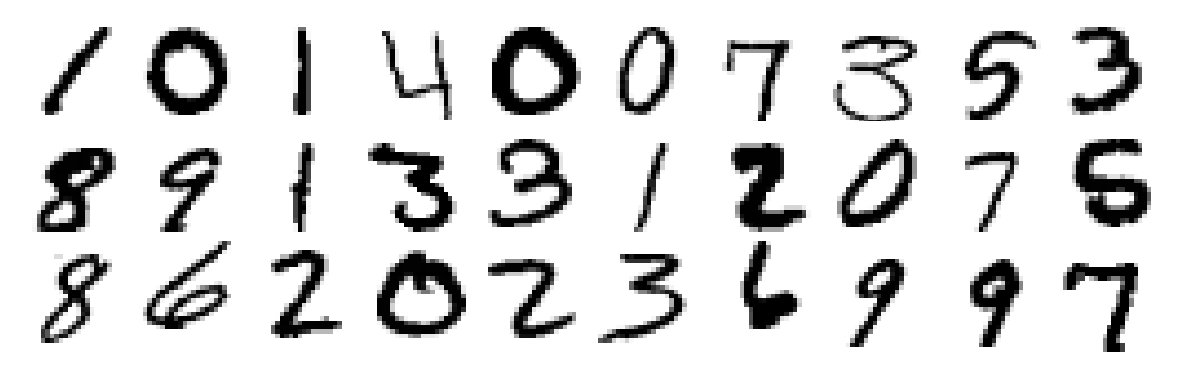

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [11]:
train.shape

(42000, 785)

In [12]:
test.shape

(28000, 784)

In [13]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

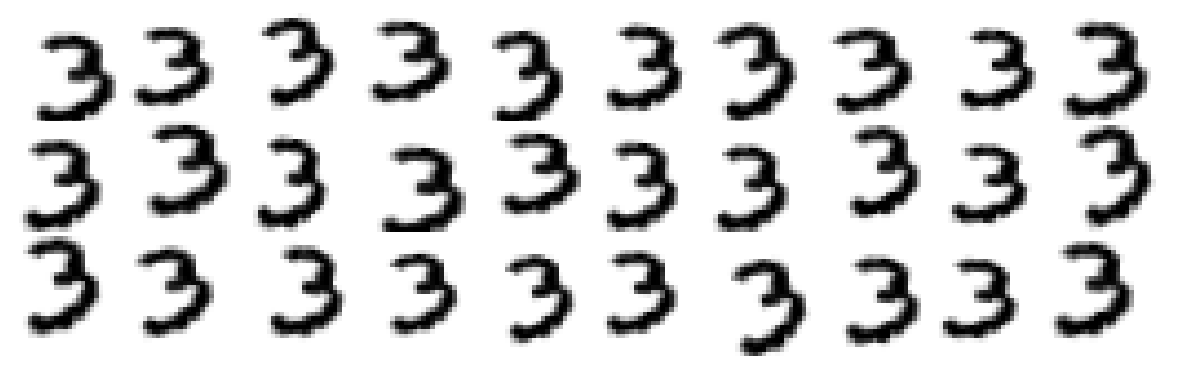

In [15]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1, 28, 28, 1))
Y_train3 = Y_train[9,].reshape((1, 10))

plt.figure(figsize=(15, 4.5))
i = 0  # Initialize the counter
for X_batch, Y_batch in datagen.flow(X_train3, Y_train3):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X_batch[0].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis('off')
    i += 1  # Increment the counter
    if i >= 30:  # Stop after 30 images
        break

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [19]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))
    
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np


# Define your CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Learning rate scheduler (example)
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 5:
        lr *= 0.2
    return lr

annealer = LearningRateScheduler(lr_schedule)

# TRAIN NETWORKS
history = [0] * nets
epochs = 45
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    
    history[j] = model.fit(  
        datagen.flow(X_train2,Y_train2, batch_size=64), 
        epochs=epochs,
        steps_per_epoch=X_train2.shape[0]//64, 
        validation_data=(X_val2,Y_val2),
        callbacks=[annealer], 
        verbose=0)
    
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1, epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy']) ))

CNN 1: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500
CNN 2: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500
CNN 3: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500
CNN 4: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99524
CNN 5: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99762
CNN 6: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99738
CNN 7: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99881
CNN 8: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99857
CNN 9: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99810
CNN 10: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99786
CNN 11: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99881
CNN 12: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99881
CNN 13: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99905
CNN 14: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99952
CNN 15: Epochs=

In [26]:
results = np.zeros( (X_test.shape[0],10) ) 
for j in range(nets):
    results = results + model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


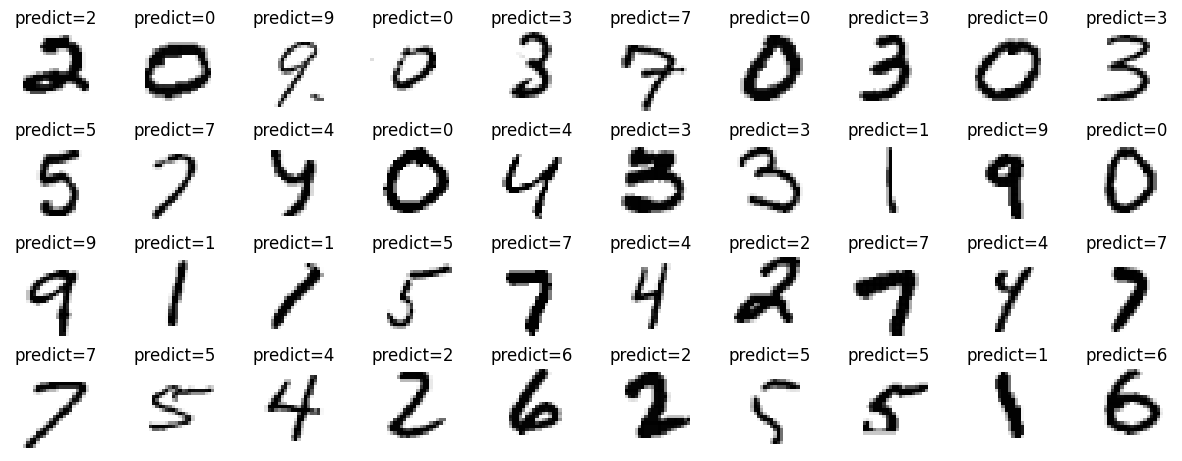

In [27]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()